In [1]:

!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.zip

!zip -F /content/Dataset_BUSI_with_GT.zip --out /content/Dataset_BUSI_with_GT_total.zip
!unzip Dataset_BUSI_with_GT_total.zip

--2024-06-11 11:43:08--  https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01 [following]
--2024-06-11 11:43:08--  https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘Dataset_BUSI_with_GT.z01’

Dataset_BUSI_with_G 100%[===================>] 100.00M   225MB/s    in 0.4s    

2024-06-11 11:43:17 (225 MB/s)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
image_size = (224,224)

# Define a transform to convert images to RGB
convert_to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
#greyscale
convert_to_grayscale = transforms.Lambda(lambda image: image.convert('L'))

train_transform=transforms.Compose([
    convert_to_rgb,
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([
    convert_to_rgb,
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
EPOCHS = 100
#batch size can also be a learnable hyperparameter, but it was not included in the grid search
BATCH_SIZE = 16

In [5]:
# Function to exclude mask files
def is_not_mask(filename):
    return not filename.endswith('_mask.png')

# 데이터셋 로드 및 전처리
ds = ImageFolder('/content/Dataset_BUSI_with_GT', transform=train_transform, is_valid_file=is_not_mask)

print(ds.classes)
print(len(ds))
image, label = ds[0]
print(image.shape)

print("Number of samples: ", len(ds))
print("Detected Classes are: ", ds.class_to_idx)

train_size = int(0.7 * len(ds)) # 70% for training
val_size = int(0.15 * len(ds)) # 15% for validation
test_size = len(ds) - train_size - val_size # 15% for testing

train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])
print(f"train: {len(train_ds)} test: {len(test_ds)} val: {len(val_ds)}")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


['benign', 'malignant', 'normal']
798
torch.Size([3, 224, 224])
Number of samples:  798
Detected Classes are:  {'benign': 0, 'malignant': 1, 'normal': 2}
train: 558 test: 121 val: 119


In [6]:
# 모델 초기화 (DenseNet-121 사용)
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

num_epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

test_predicted_classes = []
test_true_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += criterion(outputs, labels).item()

        test_predicted_classes.extend(predicted.cpu().numpy())
        test_true_classes.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 220MB/s]


Epoch [1/50], Train Loss: 0.7320, Val Loss: 7.2038, Val Acc: 0.6303
Epoch [2/50], Train Loss: 0.5757, Val Loss: 1.0059, Val Acc: 0.5966
Epoch [3/50], Train Loss: 0.4079, Val Loss: 0.8042, Val Acc: 0.6975
Epoch [4/50], Train Loss: 0.4166, Val Loss: 0.8217, Val Acc: 0.6807
Epoch [5/50], Train Loss: 0.4061, Val Loss: 0.9650, Val Acc: 0.7479
Epoch [6/50], Train Loss: 0.2728, Val Loss: 0.6532, Val Acc: 0.7731
Epoch [7/50], Train Loss: 0.3079, Val Loss: 0.6139, Val Acc: 0.8235
Epoch [8/50], Train Loss: 0.2887, Val Loss: 1.1502, Val Acc: 0.7227
Epoch [9/50], Train Loss: 0.3479, Val Loss: 0.9999, Val Acc: 0.6555
Epoch [10/50], Train Loss: 0.2779, Val Loss: 0.8401, Val Acc: 0.7143
Epoch [11/50], Train Loss: 0.2374, Val Loss: 0.5533, Val Acc: 0.7731
Epoch [12/50], Train Loss: 0.1775, Val Loss: 0.9445, Val Acc: 0.7899
Epoch [13/50], Train Loss: 0.1789, Val Loss: 0.9173, Val Acc: 0.7059
Epoch [14/50], Train Loss: 0.2413, Val Loss: 0.9341, Val Acc: 0.7815
Epoch [15/50], Train Loss: 0.1696, Val Loss

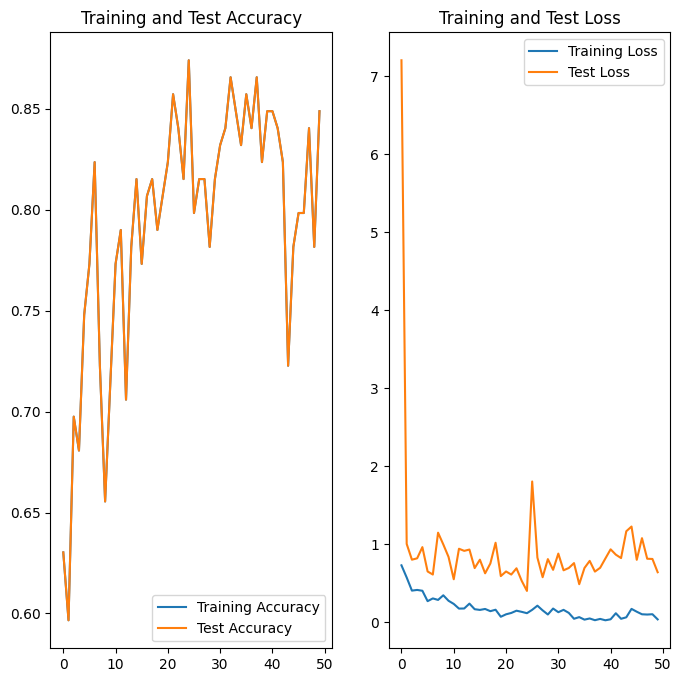

In [7]:
# 훈련 및 검증 손실 및 정확도 시각화
acc = val_accuracies
test_acc = val_accuracies

loss = train_losses
test_loss = val_losses

epochs_range = range(num_epochs)
test_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(test_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(loss).cpu(), label='Training Loss')
plt.plot(test_range, torch.tensor(test_loss).cpu(), label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

step: 0
predict: tensor([2, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2], device='cuda:0') accuracy: 81.25 loss: [0.7319929689489385, 0.5756545941675862, 0.4079119674193816, 0.4166082271965601, 0.40610945812262944, 0.27282411559721903, 0.3079152669103342, 0.2887428913492456, 0.3478695434588258, 0.27794253006310443, 0.23737698991025222, 0.1774736268238889, 0.1788665286956295, 0.2412686987669878, 0.1696314506206034, 0.16053411022736608, 0.1728042210302045, 0.14435833948914722, 0.1629842898965309, 0.07291405157963862, 0.10417969023481706, 0.1215884430020193, 0.15061862782765462, 0.13571490085680424, 0.11863869538791078, 0.16174737091666908, 0.21489123241662125, 0.15480812193698995, 0.1019616047434482, 0.17813257611353336, 0.13143357551760143, 0.16129031359455065, 0.12255159199344642, 0.047224231365580766, 0.06819468692919793, 0.03596685080385122, 0.050969121084752156, 0.028743061714381728, 0.04534305807029475, 0.02779249100980105, 0.040382953147874566, 0.11781440281032127, 0.0470322067799

step: 1
predict: tensor([0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1], device='cuda:0') accuracy: 93.75 loss: [0.7319929689489385, 0.5756545941675862, 0.4079119674193816, 0.4166082271965601, 0.40610945812262944, 0.27282411559721903, 0.3079152669103342, 0.2887428913492456, 0.3478695434588258, 0.27794253006310443, 0.23737698991025222, 0.1774736268238889, 0.1788665286956295, 0.2412686987669878, 0.1696314506206034, 0.16053411022736608, 0.1728042210302045, 0.14435833948914722, 0.1629842898965309, 0.07291405157963862, 0.10417969023481706, 0.1215884430020193, 0.15061862782765462, 0.13571490085680424, 0.11863869538791078, 0.16174737091666908, 0.21489123241662125, 0.15480812193698995, 0.1019616047434482, 0.17813257611353336, 0.13143357551760143, 0.16129031359455065, 0.12255159199344642, 0.047224231365580766, 0.06819468692919793, 0.03596685080385122, 0.050969121084752156, 0.028743061714381728, 0.04534305807029475, 0.02779249100980105, 0.040382953147874566, 0.11781440281032127, 0.0470322067799

step: 3
predict: tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0], device='cuda:0') accuracy: 87.5 loss: [0.7319929689489385, 0.5756545941675862, 0.4079119674193816, 0.4166082271965601, 0.40610945812262944, 0.27282411559721903, 0.3079152669103342, 0.2887428913492456, 0.3478695434588258, 0.27794253006310443, 0.23737698991025222, 0.1774736268238889, 0.1788665286956295, 0.2412686987669878, 0.1696314506206034, 0.16053411022736608, 0.1728042210302045, 0.14435833948914722, 0.1629842898965309, 0.07291405157963862, 0.10417969023481706, 0.1215884430020193, 0.15061862782765462, 0.13571490085680424, 0.11863869538791078, 0.16174737091666908, 0.21489123241662125, 0.15480812193698995, 0.1019616047434482, 0.17813257611353336, 0.13143357551760143, 0.16129031359455065, 0.12255159199344642, 0.047224231365580766, 0.06819468692919793, 0.03596685080385122, 0.050969121084752156, 0.028743061714381728, 0.04534305807029475, 0.02779249100980105, 0.040382953147874566, 0.11781440281032127, 0.04703220677992

step: 4
predict: tensor([0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0], device='cuda:0') accuracy: 93.75 loss: [0.7319929689489385, 0.5756545941675862, 0.4079119674193816, 0.4166082271965601, 0.40610945812262944, 0.27282411559721903, 0.3079152669103342, 0.2887428913492456, 0.3478695434588258, 0.27794253006310443, 0.23737698991025222, 0.1774736268238889, 0.1788665286956295, 0.2412686987669878, 0.1696314506206034, 0.16053411022736608, 0.1728042210302045, 0.14435833948914722, 0.1629842898965309, 0.07291405157963862, 0.10417969023481706, 0.1215884430020193, 0.15061862782765462, 0.13571490085680424, 0.11863869538791078, 0.16174737091666908, 0.21489123241662125, 0.15480812193698995, 0.1019616047434482, 0.17813257611353336, 0.13143357551760143, 0.16129031359455065, 0.12255159199344642, 0.047224231365580766, 0.06819468692919793, 0.03596685080385122, 0.050969121084752156, 0.028743061714381728, 0.04534305807029475, 0.02779249100980105, 0.040382953147874566, 0.11781440281032127, 0.0470322067799

step: 6
predict: tensor([0, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0], device='cuda:0') accuracy: 93.75 loss: [0.7319929689489385, 0.5756545941675862, 0.4079119674193816, 0.4166082271965601, 0.40610945812262944, 0.27282411559721903, 0.3079152669103342, 0.2887428913492456, 0.3478695434588258, 0.27794253006310443, 0.23737698991025222, 0.1774736268238889, 0.1788665286956295, 0.2412686987669878, 0.1696314506206034, 0.16053411022736608, 0.1728042210302045, 0.14435833948914722, 0.1629842898965309, 0.07291405157963862, 0.10417969023481706, 0.1215884430020193, 0.15061862782765462, 0.13571490085680424, 0.11863869538791078, 0.16174737091666908, 0.21489123241662125, 0.15480812193698995, 0.1019616047434482, 0.17813257611353336, 0.13143357551760143, 0.16129031359455065, 0.12255159199344642, 0.047224231365580766, 0.06819468692919793, 0.03596685080385122, 0.050969121084752156, 0.028743061714381728, 0.04534305807029475, 0.02779249100980105, 0.040382953147874566, 0.11781440281032127, 0.0470322067799

IndexError: index 7 is out of bounds for dimension 0 with size 7

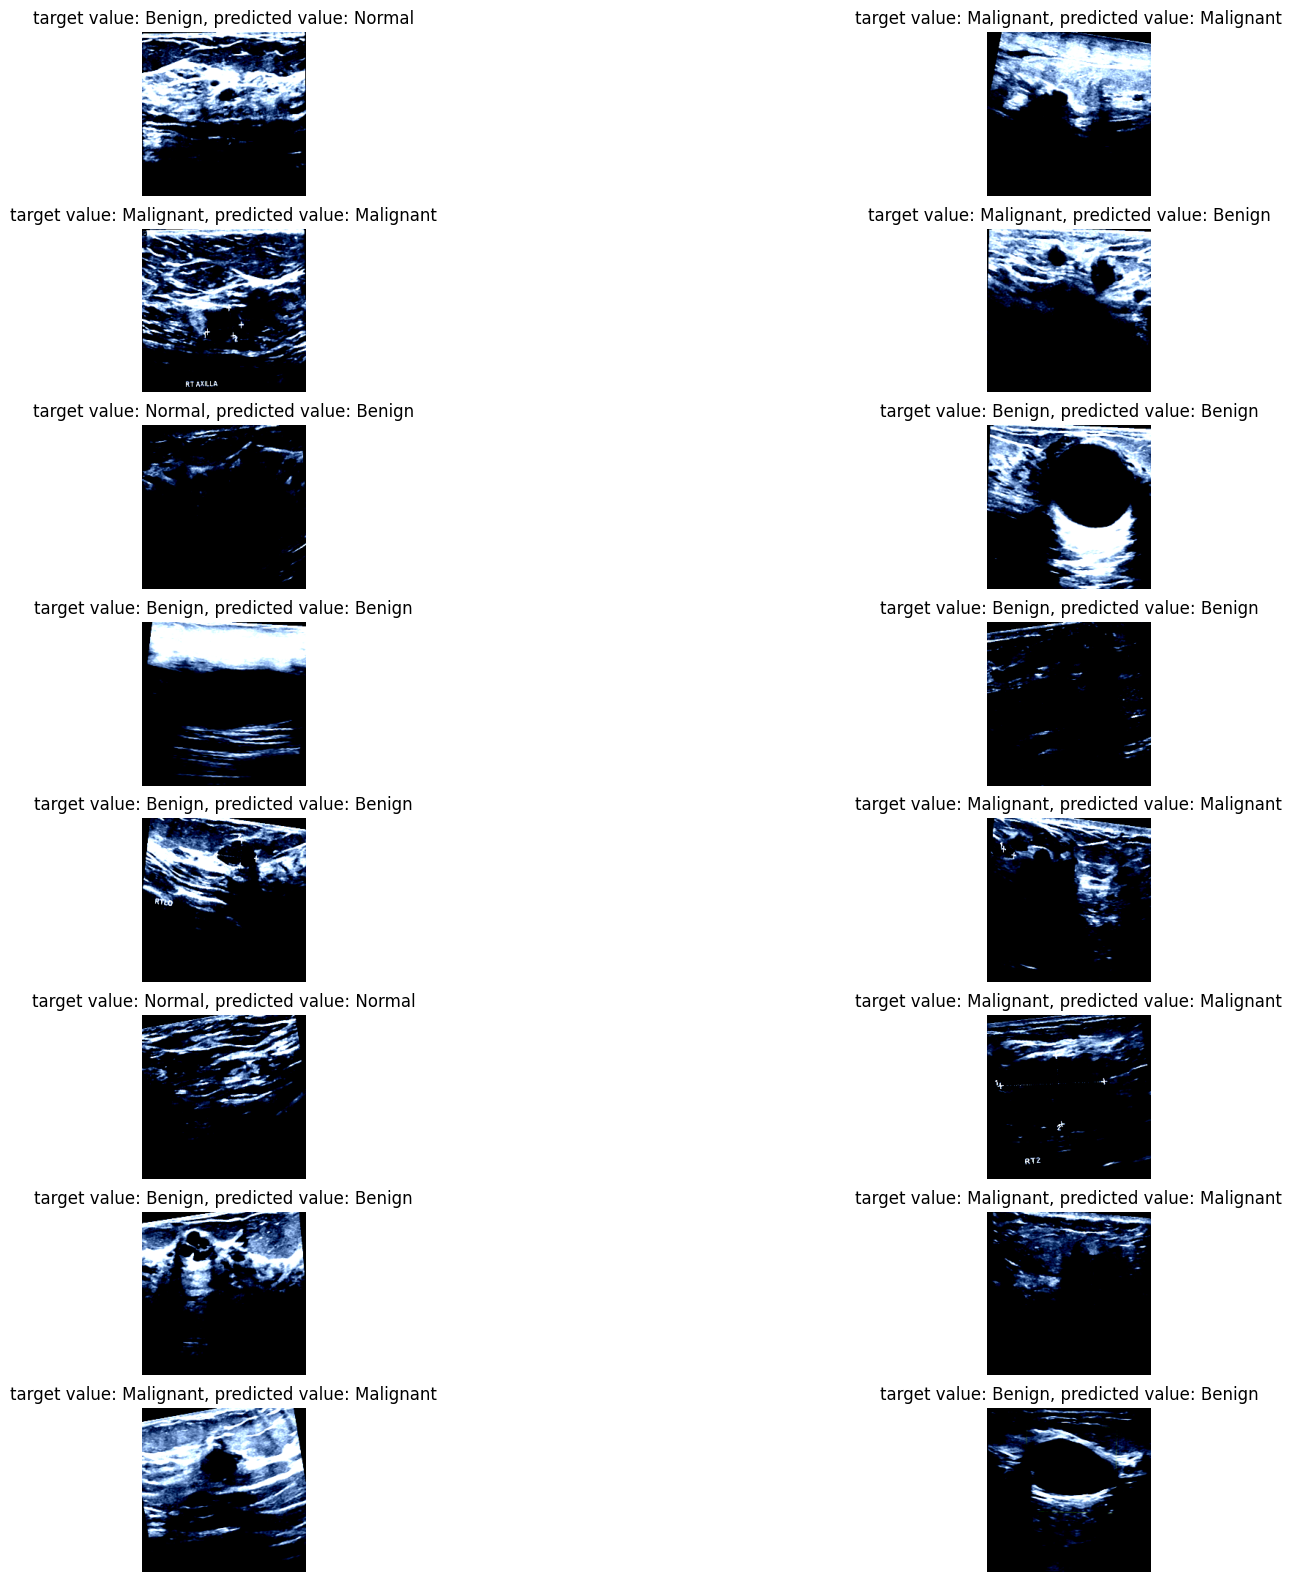

In [8]:
EVAL_BATCH = 16
eval_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plt.figure(figsize=(20, 20))

# Disable grad
with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, eval_predictions = torch.max(outputs, 1)
        acc_value = (eval_predictions == y)
        accuracy = acc_value.sum().item() / len(acc_value) * 100
        print(f"step: {step}")
        print(f"predict: {eval_predictions} accuracy: {accuracy} loss: {loss}")
        print(f"targets: {y}")

        for i in range(EVAL_BATCH):
            value_predicted = "Benign" if eval_predictions[i].item() == 0 else "Malignant" if eval_predictions[i].item() == 1 else "Normal"
            value_target = "Benign" if y[i].item() == 0 else "Malignant" if y[i].item() == 1 else "Normal"

            image = x[i].cpu()
            ax = plt.subplot(int(EVAL_BATCH/2), int(EVAL_BATCH/8), i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"target value: {value_target}, predicted value: {value_predicted}")
            ax.set_axis_off()

[[53  5  6]
 [ 6 24  2]
 [ 4  0 21]]


Text(0.5, 47.7222222222222, 'Predicted Labels')

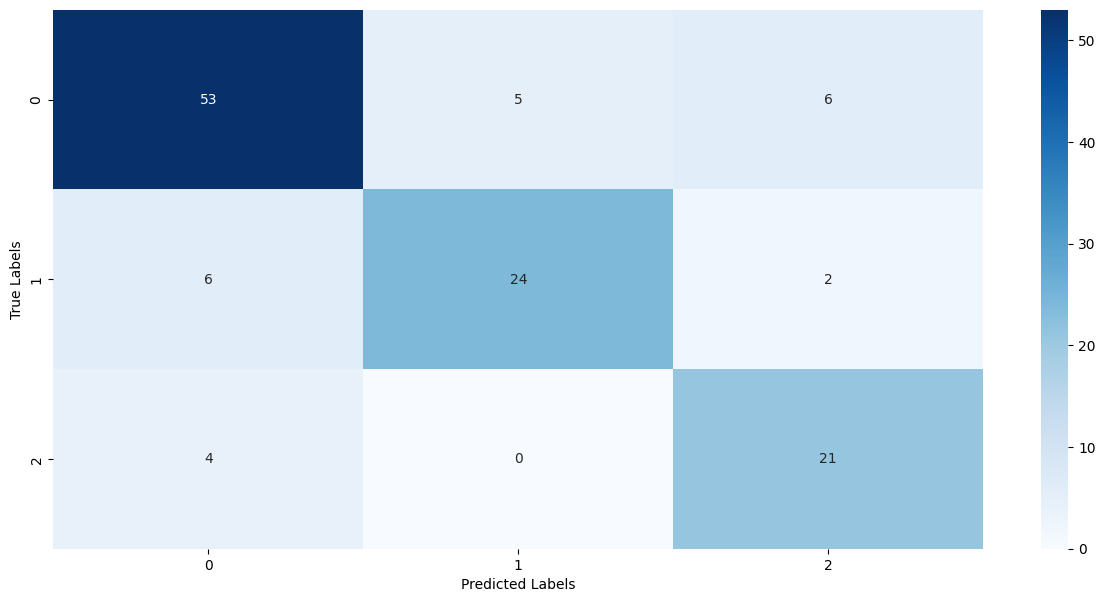

In [9]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_true_classes, test_predicted_classes)
print(conf_mat)
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')